In [1]:
from os import chdir
chdir('..')

In [14]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import numpy as np
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString
from shapely.affinity import scale

from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes
%matplotlib notebook
sns.set()
sns.set_style("whitegrid")

In [30]:
def plot_points(ax, points, color=''):
    ax.scatter(points[:, 0], points[:, 1], c=color)
    
def plot_triangles(ax, points, triangles, mask=None, lw=1.0, **kwargs):
    ax.triplot(points[:,0], points[:, 1], triangles,  mask=mask, lw=lw, **kwargs)

def next_half_edge(e):
    return e - 2 if e % 3 == 2 else e + 1

def get_pi(t, i):
    return t * 3 + i

def build_tri_hash(plane):
    return {t:t for t in plane}

def build_line_string(points, delaunay, e1):
    triangles = delaunay.triangles
    e2 = next_half_edge(e1)
    
    pi1 = triangles[e1]
    pi2 = triangles[e2]
    
    point1 = points[pi1, :]
    point2 = points[pi2,:]
    return LineString([point1, point2])
    

def build_edge_classification(points, delaunay, plane, tri_hash):
    halfedges = delaunay.halfedges
    edgeclass = dict()
    edges = dict()
    # Loop through every triangle in the plane
    for t in plane:
        # Loop through every half edge in triangle
        for i in range(3):
            heIndex = t * 3 + i
            # get the adjacent edge of this triangle edge
            oppHe = halfedges[heIndex]
            oppT = math.floor(oppHe / 3)
            # check if this triangle (oppT) is on the convex hull or removed
            if tri_hash.get(oppT) is None:
                edgeclass[heIndex] = True
                edges[heIndex] = build_line_string(points, delaunay, heIndex)
#                 print('BLUE', edges[heIndex].wkt)
            else:
                edgeclass[heIndex] = False
                edges[heIndex] = build_line_string(points, delaunay, heIndex)
#                 print('GRAY', edges[heIndex].wkt)
                
    return edgeclass, edges
            

def is_boundary_edge(delaunay, tri_hash, e):
    halfedges = delaunay.halfedges
    edge
    if halfedges[e] == -1:
        return True
    else:
        return False
    
def plot_halftriangles(ax, points, delaunay, plane):
    tri_hash = build_tri_hash(plane)
    edgeclass, edges = build_edge_classification(points, delaunay, plane, tri_hash)
    
    for e, ls in edges.items():
        color = BLUE if edgeclass[e] else GRAY
        plot_arrow(ax, ls, color=color, width=0.02, scale_factor=0.75, 
                   offset=0.04, offset_side='right', shape='full',length_includes_head=True)
    
    
def get_mask(triangles, planes):
    mask_array = np.ones(triangles.shape[0], dtype=bool)
    mask_array[planes[0]] = False
    return mask_array

points, poly = fake_building(x_dim=[0, 7, 1])

In [4]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
# plot_points(ax, points)


In [27]:
# ls = LineString([(0,0), (1, 0)])
# list(reversed(ls.parallel_offset(1, 'right').coords))
# # what I want [ (0.0, -1.0), (1.0, -1.0),]

<IPython.core.display.Javascript object>


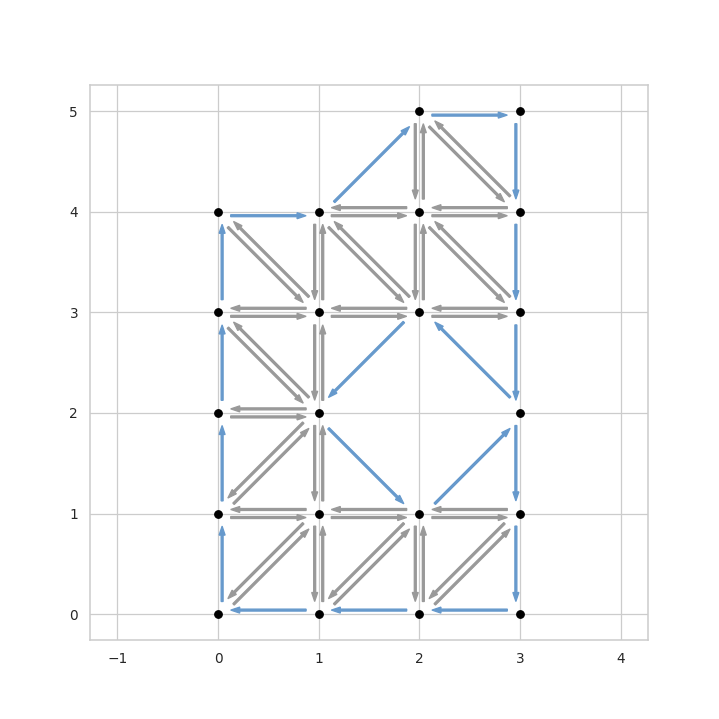

(-0.1553225806451613,
 3.1553225806451612,
 -0.2553571428571429,
 5.255357142857143)

In [31]:
points, poly = fake_building(x_dim=[0, 4, 1], y_dim=[0, 4, 1], holes=[[2,2,0.5]])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

delaunay, planes, polygons = extractPlanesAndPolygons(points, xyThresh=1.5, minTriangles=10, alpha=0.0)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
mask = get_mask(triangles, planes)
# plot_triangles(ax, points, triangles, mask=mask,lw=1.0)
plot_points(ax, points, color='black')
plot_halftriangles(ax, points, delaunay, planes[0])
map_bounds = poly.bounds
scale_axes([map_bounds[0], map_bounds[2]], [
            map_bounds[1], map_bounds[3]], ax)
ax.axis('equal')

# NOTE this is triangles are going clocwise in this right hand coordinate system
# x -> right, y-> up (not down!)


GRAY LINESTRING (2.252139873161029 0.7890873681040131, 2.834423605838594 1.221295366343742)
BLUE LINESTRING (2.834423605838594 1.221295366343742, 2.253976801481989 0.4000926736195762)
GRAY LINESTRING (2.253976801481989 0.4000926736195762, 2.252139873161029 0.7890873681040131)
GRAY LINESTRING (2.834423605838594 1.221295366343742, 2.252139873161029 0.7890873681040131)
GRAY LINESTRING (2.252139873161029 0.7890873681040131, 1.543007774268548 1.745080085180547)
BLUE LINESTRING (1.543007774268548 1.745080085180547, 2.834423605838594 1.221295366343742)
GRAY LINESTRING (2.252139873161029 0.7890873681040131, 2.253976801481989 0.4000926736195762)
BLUE LINESTRING (2.253976801481989 0.4000926736195762, 0.7975977401427464 0.7139683131356469)
GRAY LINESTRING (0.7975977401427464 0.7139683131356469, 2.252139873161029 0.7890873681040131)
GRAY LINESTRING (1.543007774268548 1.745080085180547, 2.252139873161029 0.7890873681040131)
GRAY LINESTRING (2.252139873161029 0.7890873681040131, 0.7975977401427464 0

(-6.311463444488877, 5.808254543485276, -5.589063417575403, 5.9974988943483)

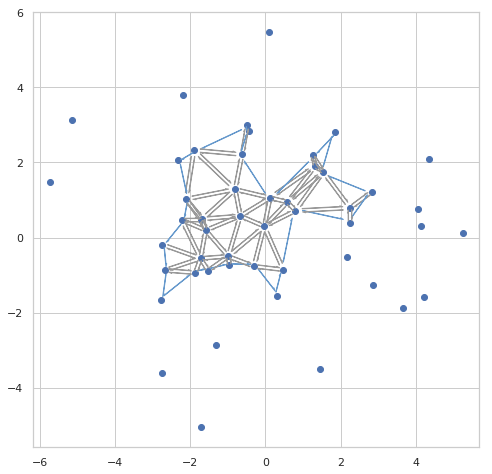

In [7]:
np.random.seed(1)
num_points = 50
std = 0.25
x = np.random.normal(0, std, size=num_points) * 10
y = np.random.normal(0, std, size=num_points) * 10
points = np.column_stack((x,y))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

delaunay, planes, polygons = extractPlanesAndPolygons(points, alpha=0.9)
triangles = np.asarray(delaunay.triangles).reshape(int(len(delaunay.triangles)/ 3), 3)
mask_array = np.ones(triangles.shape[0], dtype=bool)
mask_array[planes[0]] = False
# mask_array = ~mask_array
plot_points(ax, points)
plot_halftriangles(ax, points, delaunay, planes[0])
map_bounds = poly.bounds
scale_axes([map_bounds[0], map_bounds[2]], [
            map_bounds[1], map_bounds[3]], ax)
ax.axis('equal')
